# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [2]:
# Enter your information here
first_and_last_name = 'Ali Ghasemzadeh'
std_number = '401106339'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [2]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [4]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mu = np.mean(x, axis=0)
    var = np.var(x, axis=0)

    normalized_x = (x - mu) / np.sqrt(var + epsilon)
    y = gamma*normalized_x + beta
    return y

In [4]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [16]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])




# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
train_subset_indices = list(range(len(train_set) // 2))
train_subset = Subset(train_set, train_subset_indices)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=False)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# TODO: create test
test_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>

- The transform_train applies data augmentation (random cropping and horizontal flipping) to increase variability in the training data, followed by converting images to tensors and normalizing them for stable training.

- The transform_test ensures consistency during evaluation by resizing images to a fixed size, converting them to tensors, and normalizing them in the same way as the training data.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

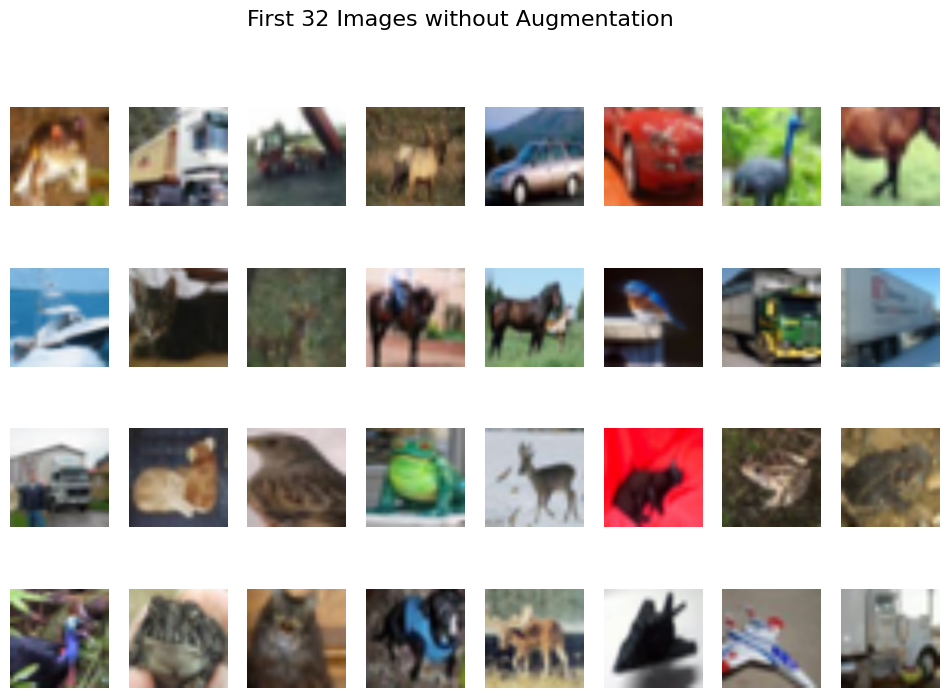

Labels :  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])


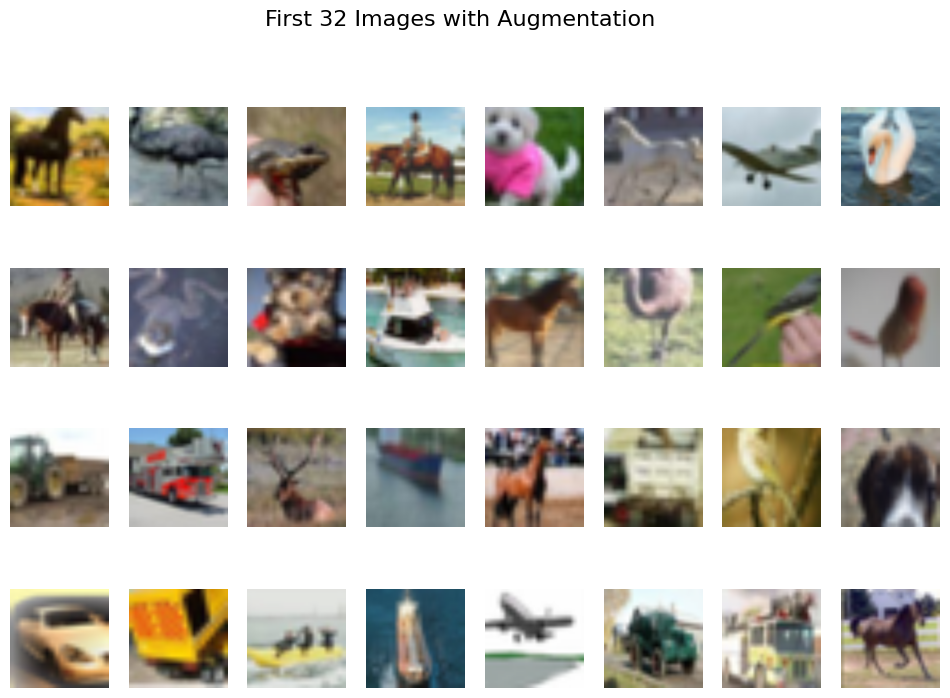

labels :  tensor([7, 2, 6, 7, 5, 7, 0, 2, 7, 6, 5, 8, 7, 2, 2, 2, 9, 9, 4, 8, 7, 9, 2, 5,
        1, 9, 8, 8, 0, 9, 9, 7])


In [17]:
def imshow(img):
    # TODO:
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    img = img.numpy().transpose((1, 2, 0))  
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.axis('off')

# show some training images with shuffle=False and labels
train_loader = DataLoader(train_subset, batch_size=128, shuffle=False, num_workers=4)
data_iter = iter(train_loader)
images, labels = next(data_iter)
plt.figure(figsize=(12, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    imshow(images[i])
plt.suptitle("First 32 Images without Augmentation", fontsize=16)
plt.show()
# show them again to check the augmentation
train_loader_augmented = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
data_iter_aug = iter(train_loader_augmented)
images_aug, labels_aug = next(data_iter_aug)

# create train loader with shuffle true
print("Labels : ", labels[:32])
plt.figure(figsize=(12, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    imshow(images_aug[i])
plt.suptitle("First 32 Images with Augmentation", fontsize=16)
plt.show()
print("labels : ", labels_aug[:32])


For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [25]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    losses = []
    if train_mode:
        model.train()
    else:
        model.eval()

    for inputs, labels in tqdm(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.set_grad_enabled(train_mode):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        losses.append(loss.item())

    return losses

def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_epoch_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        val_epoch_losses = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)

        train_loss_avg = np.mean(train_epoch_losses)
        val_loss_avg = np.mean(val_epoch_losses)

        train_losses.extend(train_epoch_losses)
        val_losses.extend(val_epoch_losses)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss_avg:.4f}, "
              f"Validation Loss: {val_loss_avg:.4f}")

        if val_loss_avg == min(val_losses):
            torch.save(model.state_dict(), MODEL_SAVE_PATH)

    return train_losses, val_losses

def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total 



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    train_losses = np.convolve(train_losses, np.ones(c_window) / c_window, mode='valid')
    val_losses = np.convolve(val_losses, np.ones(c_window) / c_window, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    plt.show()


Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [26]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),  # Standard convolution
        nn.BatchNorm2d(oup),  # Batch normalization
        nn.ReLU(inplace=True)  # ReLU activation
    )


def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
        # Depthwise convolution
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),
        
        # Pointwise convolution
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.

### Depthwise Separable Convolutions: Parameter Reduction and Speed Improvement

Depthwise Separable Convolutions reduce the number of parameters and computational cost by splitting the standard convolution operation into two steps: **depthwise convolution** and **pointwise convolution**.

---

#### Normal Convolution:
For an input tensor of size \( H \times W \times C_{in} \) and a filter size of \( K \times K \) with \( C_{out} \) filters, the total number of parameters is:
\[
C_{in} \times K \times K \times C_{out}
\]

---

#### Depthwise Separable Convolution:
1. **Depthwise Convolution**: Applies one \( K \times K \) filter per input channel:
   \[
   C_{in} \times K \times K
   \]

2. **Pointwise Convolution**: Applies \( 1 \times 1 \) convolutions to combine the channels:
   \[
   C_{in} \times C_{out}
   \]

**Total Parameters**:
\[
C_{in} \times K \times K + C_{in} \times C_{out}
\]

---

#### Parameter Reduction:
The ratio of parameters in Depthwise Separable Convolution to Normal Convolution is:
\[
\frac{C_{in} \times K \times K + C_{in} \times C_{out}}{C_{in} \times K \times K \times C_{out}}
\]

For typical values (e.g., \( K=3 \)), this results in an **8-9x reduction** in parameters.

---

#### Speed Improvement:
Depthwise Separable Convolutions significantly reduce the number of multiplications, making models computationally lighter and faster. This is especially beneficial on resource-constrained devices, such as mobile hardware.


Now please create your model.

In [27]:
import torch
import torch.nn as nn

class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()

        self.model = nn.Sequential(
            conv_bn(3, 32, stride=2),  # Conv / s2
            conv_dw(32, 64, stride=1),  # Conv dw / s1
            conv_dw(64, 128, stride=2),  # Conv dw / s2
            conv_dw(128, 128, stride=1),  # Conv dw / s1
            conv_dw(128, 256, stride=2),  # Conv dw / s2
            conv_dw(256, 256, stride=1),  # Conv dw / s1
            conv_dw(256, 512, stride=2),  # Conv dw / s2
            # 5x (Conv dw / s1 -> Conv / s1)
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 1024, stride=2),  # Conv dw / s2
            conv_dw(1024, 1024, stride=1),  # Conv dw / s1
            nn.AvgPool2d(kernel_size=7)  # Avg Pool 7 x 7
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        # Pass through the model
        x = self.model(x)
        # Flatten the output before the fully connected layer
        x = x.view(-1, 1024)
        # Pass through the fully connected layer
        x = self.fc(x)
        return x


Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [28]:
model = MobileNet().to(device)
print("Total number of MobileNet parameters: ", sum(p.numel() for p in model.parameters()))

Total number of MobileNet parameters:  4231976


In [29]:
epochs = 10
lr = 1e-3
# TODO:

model = MobileNet().to(device)
t_start = time.time()
train_losses, val_losses = train(
    train_loader=train_loader,
    val_loader=test_loader,
    model=model,
    epochs=epochs,
    lr=lr
)
t_end = time.time()

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 1.7240, Validation Loss: 1.7407


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 1.3013, Validation Loss: 1.2296


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 1.1146, Validation Loss: 1.1261


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.9924, Validation Loss: 1.1001


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.8837, Validation Loss: 0.9361


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.7992, Validation Loss: 0.7946


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.7220, Validation Loss: 0.7824


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.6720, Validation Loss: 0.6810


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.6116, Validation Loss: 0.6386


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.5652, Validation Loss: 0.6324


In [30]:
print(f"trian time : {(t_end - t_start)/60:.4} minutes")

trian time : 16.47 minutes


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 78.62
Process validation time: 13.3882 s


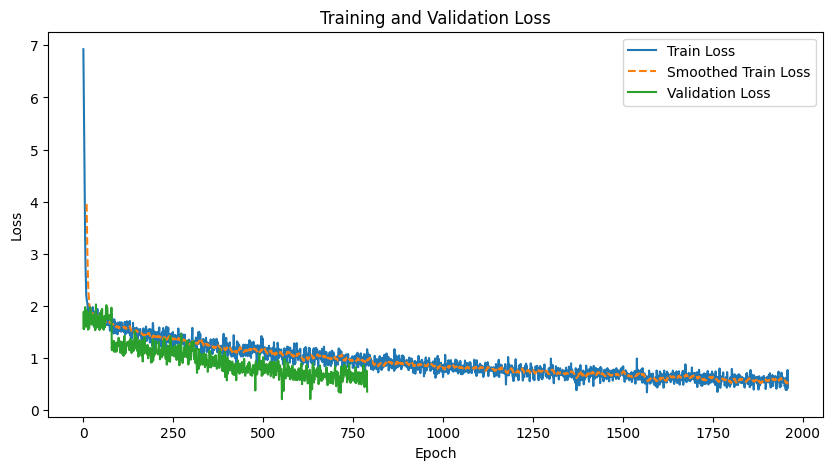

In [31]:
start = time.time()
val_acc = get_acc(model, test_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


# Why MobileNet is 8–9 Times Faster: FLOPs Comparison

MobileNet achieves its speedup by replacing **standard convolution** with **depthwise separable convolution**. Let’s calculate the FLOPs (Floating Point Operations) for both and understand how the 8–9x factor arises.

---

## 1. Standard Convolution

In standard convolution, every input channel is convolved with a kernel, and the results are summed to produce an output channel. The FLOPs are:

$
\text{FLOPs}_{\text{standard}} = H_{\text{out}} \cdot W_{\text{out}} \cdot C_{\text{in}} \cdot C_{\text{out}} \cdot K \cdot K
$

Where:
- \( H_{\text{out}}, W_{\text{out}} \): Height and width of the output feature map
- \( C_{\text{in}} \): Number of input channels
- \( C_{\text{out}} \): Number of output channels
- \( K \): Kernel size (e.g., \( K = 3 \))

---

## 2. Depthwise Separable Convolution

Depthwise separable convolution splits the operation into two steps:

1. **Depthwise convolution**: Each input channel is convolved independently.
2. **Pointwise convolution**: A \( 1 $\times$ 1 \) kernel combines these independent outputs.

### a. Depthwise Convolution
The FLOPs are:

$
\text{FLOPs}_{\text{depthwise}} = H_{\text{out}} \cdot W_{\text{out}} \cdot C_{\text{in}} \cdot K \cdot K
$

### b. Pointwise Convolution
The FLOPs are:

$
\text{FLOPs}_{\text{pointwise}} = H_{\text{out}} \cdot W_{\text{out}} \cdot C_{\text{in}} \cdot C_{\text{out}}
$

### Total FLOPs for Depthwise Separable Convolution
$
\text{FLOPs}_{\text{separable}} = H_{\text{out}} \cdot W_{\text{out}} \cdot \big(C_{\text{in}} \cdot K \cdot K + C_{\text{in}} \cdot C_{\text{out}} \big)
$

---

## 3. Comparing FLOPs

### Standard Convolution
$
\text{FLOPs}_{\text{standard}} = H_{\text{out}} \cdot W_{\text{out}} \cdot C_{\text{in}} \cdot C_{\text{out}} \cdot K \cdot K
$

### Depthwise Separable Convolution
$
\text{FLOPs}_{\text{separable}} = H_{\text{out}} \cdot W_{\text{out}} \cdot \big(C_{\text{in}} \cdot K \cdot K + C_{\text{in}} \cdot C_{\text{out}} \big)
$

### Ratio of FLOPs
The speedup is:

$
\text{Speedup} = \frac{\text{FLOPs}_{\text{standard}}}{\text{FLOPs}_{\text{separable}}}
$

Substituting the formulas:

$
\text{Speedup} = \frac{C_{\text{in}} \cdot C_{\text{out}} \cdot K \cdot K}{C_{\text{in}} \cdot K \cdot K + C_{\text{in}} \cdot C_{\text{out}}}
$

### Simplification
If \( $C_{\text{in}}$ \) is large and \( K $\cdot$ K \) (e.g., \( 3 $\times 3$ \)) is small:

$
\text{Speedup} \approx \frac{C_{\text{out}}}{1 + C_{\text{out}} / K^2}
$

For typical settings like \( K = 3 \) (so \( K^2 = 9 \)) and \( $C_{\text{out}} \gg K^2$ \):

$
\text{Speedup} \approx 8 \text{ to } 9 \text{ times}
$

---

## 4. Conclusion

Depthwise separable convolution significantly reduces the computational cost by breaking the convolution into two simpler steps. This reduction leads to an **8–9x speedup** compared to standard convolution, especially for typical settings in MobileNet.


## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [32]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
# TODO: train model
cnn_model = NormalCNN().to(device)
cnn_epochs = 2
cnn_lr = 1e-3
cnn_t_start = time.time()
cnn_train_losses, cnn_val_losses = train(
    train_loader=train_loader,
    val_loader=test_loader,
    model=cnn_model,
    epochs=cnn_epochs,
    lr=cnn_lr
)
cnn_t_end = time.time()

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 2.0131, Validation Loss: 2.0748


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=2, lr=0.001
Val accuracy = 34.32
Process validation time: 19.4414 s


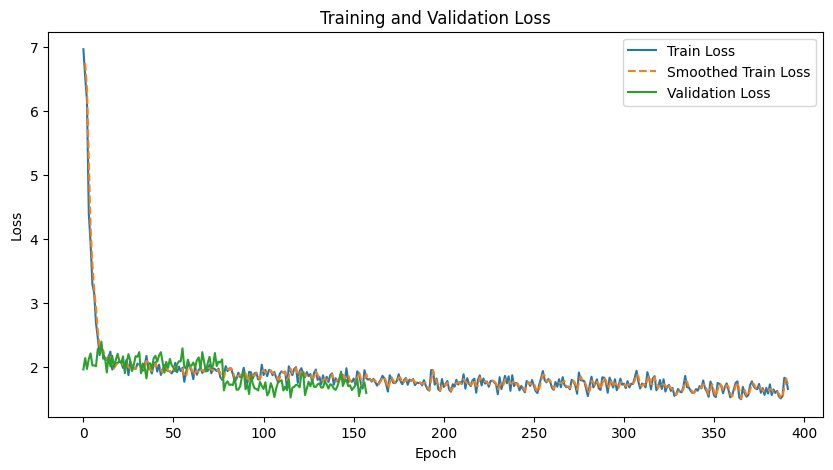

In [34]:
start = time.time()
val_acc = get_acc(cnn_model, test_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, cnn_epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(cnn_train_losses, cnn_val_losses, 2)

Compare speed of learning and validating in normal CNN vs MobileNet

- as we expect cnn is much slower than mobilenet and each epoch in cnn take 2.5 minutes while each epoch in mobilenet takes about 1.5 minutes

In [35]:
# TODO: compare number of parameters in these two models
print("Total number of normal CNN parameters: ", sum(p.numel() for p in cnn_model.parameters()))
print("Total number of MobileNet parameters: ", sum(p.numel() for p in model.parameters()))

Total number of normal CNN parameters:  29294088
Total number of MobileNet parameters:  4231976


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [36]:
ready_model = MobileNet(n_class=100).to(device)

#Todo:

# Load the pre-trained weights for the layers that match (excluding the final fc layer)
pretrained_dict = torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=True)
pretrained_dict = {k.replace('model.', ''): v for k, v in pretrained_dict.items()}
# Filter out unnecessary keys from the pretrained dict
model_dict = ready_model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}
model_dict.update(pretrained_dict)
ready_model.load_state_dict(model_dict)
# Load the updated state dict into the model
ready_model.fc = nn.Linear(1024, 100).to(device)

ready_model.eval()

MobileNet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1, 1),

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [37]:
# Freeze up to the desired layer (e.g., the first 7 layers)
count = 0
for _, param in ready_model.named_parameters():
    if count < 7:
        param.requires_grad = False
    count += 1

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [38]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 169001437/169001437 [00:02<00:00, 68009334.13it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

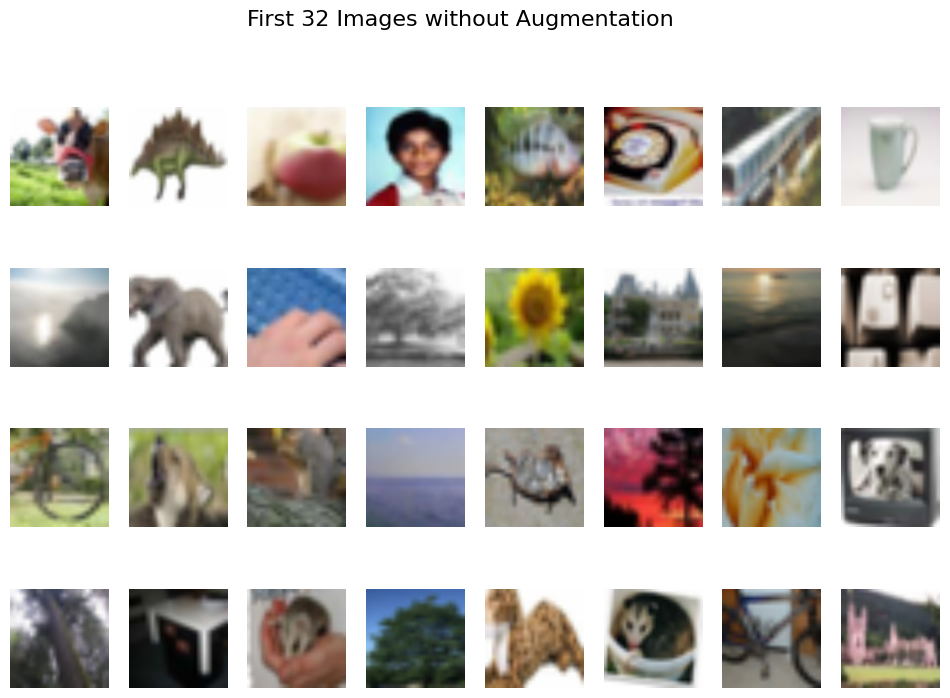

labesls are:  tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39,  8, 97,
        80, 71, 74, 59, 70, 87, 59, 84, 64, 52, 42, 64,  8, 17])


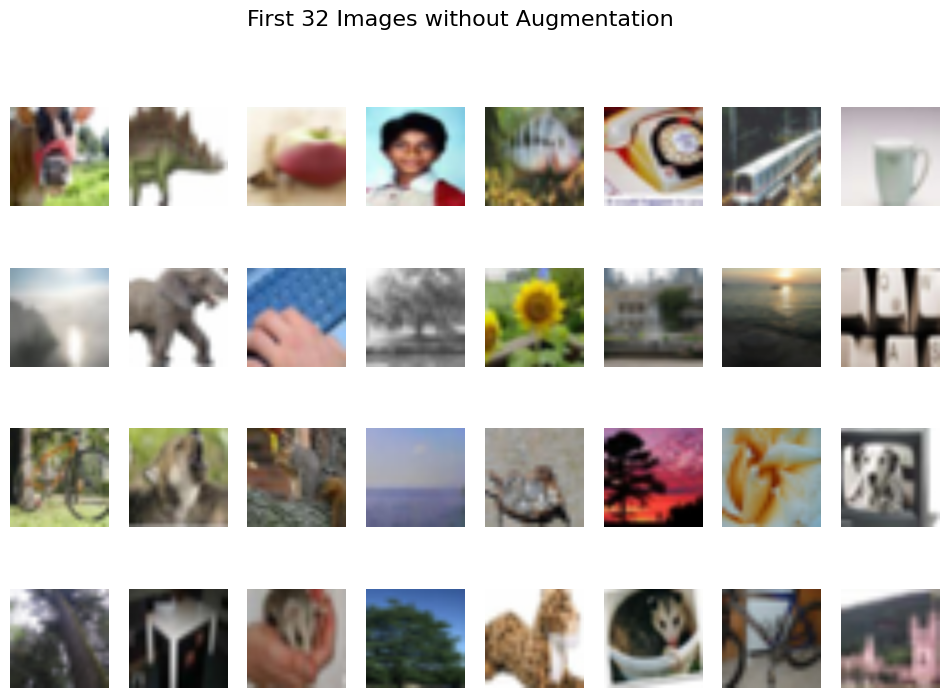

labesls are:  tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39,  8, 97,
        80, 71, 74, 59, 70, 87, 59, 84, 64, 52, 42, 64,  8, 17])


In [39]:
# show some training images with shuffle=False and labels
transform_loader = DataLoader(train_set100, batch_size=32, shuffle=False)
iteration = iter(transform_loader)
images, labels = next(iteration)
plt.figure(figsize=(12, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    imshow(images[i])
plt.suptitle("First 32 Images without Augmentation", fontsize=16)
plt.show()
print("labesls are: ", labels)
# show them again to check the augmentation
transform_loader = DataLoader(train_set100, batch_size=32, shuffle=False)
iteration = iter(transform_loader)
images, labels = next(iteration)
plt.figure(figsize=(12, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    imshow(images[i])
plt.suptitle("First 32 Images without Augmentation", fontsize=16)
plt.show()
print("labesls are: ", labels)

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

- CIFAR-10 and CIFAR-100 do not use the same images. Both datasets come from the same source, the 80 million tiny images dataset, and have the same image format and size, but they contain different images and have distinct labeling systems.

- CIFAR-10 has 10 classes (like airplane, dog, car, etc.), while CIFAR-100 has 100 classes, which are further grouped into 20 superclasses. Each image in CIFAR-100 has both a "fine" label (specific class) and a "coarse" label (the superclass it belongs to). So, while they’re related in structure and origin, they don’t overlap in content or labels.

Now train your model using your functions.

In [40]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, ready_model, epochs, lr)

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/7, Train Loss: 4.2869, Validation Loss: 4.0809


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/7, Train Loss: 3.8434, Validation Loss: 3.7707


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/7, Train Loss: 3.5979, Validation Loss: 3.5369


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/7, Train Loss: 3.3910, Validation Loss: 3.4030


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/7, Train Loss: 3.2258, Validation Loss: 3.2683


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/7, Train Loss: 3.0653, Validation Loss: 3.1418


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/7, Train Loss: 2.9445, Validation Loss: 2.9942


Get some metrics and plot your losses.

In [41]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))



Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.91
Process validation time: 12.9512 s


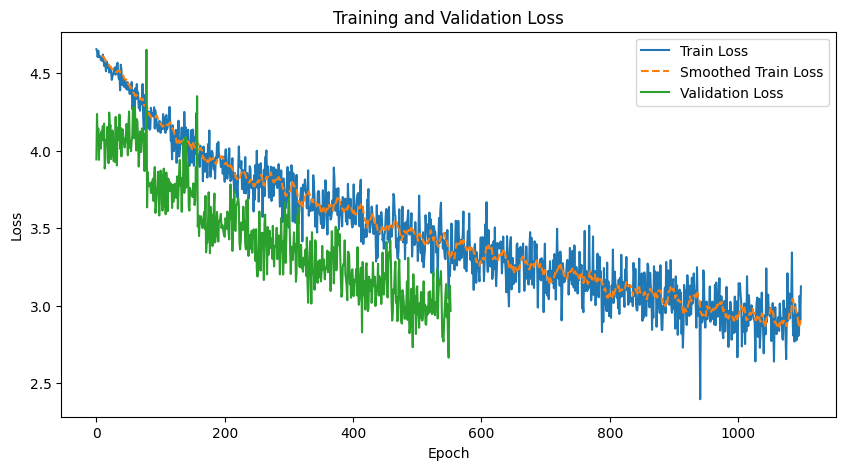

In [43]:

plot_losses(train_losses, val_losses, 7)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

- ReLU6(x)=min(max(0,x),6)
- Efficiency in Low-Precision Computing
ReLU6 is often used in models designed for mobile devices or embedded systems where computations are performed with limited precision, like 8-bit integers. The cap at 6 helps avoid numerical overflow in these scenarios.

- Better Stability
By capping the maximum value at 6, ReLU6 prevents extremely large outputs, which can cause problems like exploding gradients during training. This makes the training process more stable.

- Natural Regularization
The cap can act as a regularizer by limiting the range of activations, which helps prevent overfitting and ensures the model doesn’t rely on very high activations to make predictions.

- Specifically Designed for Lightweight Models
ReLU6 is commonly used in architectures like MobileNet, which are optimized for speed and efficiency on devices with limited computational resources.

In [58]:

def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),  # Standard 3x3 convolution
        nn.BatchNorm2d(oup),  # Batch normalization
        nn.ReLU6(inplace=True)  # ReLU6 activation
    )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),  # 1x1 convolution
        nn.BatchNorm2d(oup),  # Batch normalization
        nn.ReLU6(inplace=True)  # ReLU6 activation
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        # Inverted Residual block with optional skip connection
        # inp: input channels
        # oup: output channels
        # stride: stride for depthwise convolution
        # expand_ratio: multiplier for the hidden dimension size

        super(InvertedResidual, self).__init__()

        # Determine if a skip connection should be used

        # (only used when stride is 1 and input channels == output channels)
        self.use_residual = stride == 1 and inp == oup

        # Calculate the number of hidden channels after expansion
        hidden_dim = round(inp * expand_ratio)

        # If expand_ratio is 1, skip the initial pointwise convolution
        if expand_ratio == 1:
                self.conv = nn.Sequential(
                    # Depthwise convolution
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    nn.ReLU6(inplace=True),
                    # Pointwise-linear convolution
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(oup),
                )

        else:
            self.conv = nn.Sequential(
                # Pointwise convolution to increase channel depth
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim), 
                nn.ReLU6(inplace=True),
                # Depthwise convolution
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Pointwise-linear convolution to reduce channel depth
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup)
            )

    def forward(self, x):
        # Forward pass with optional residual connection
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [75]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        interverted_residual_setting = [# t, c, n, s
                                        [1, 16, 1, 1],
                                        [6, 24, 2, 2],
                                        [6, 32, 3, 2],
                                        [6, 64, 4, 2],
                                        [6, 96, 3, 1],
                                        [6, 160, 3, 2],
                                        [6, 320, 1, 1] ]

        # building first layer
        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier) if width_multiplier > 1.0 else 1280
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, last_channel))
        self.features.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*self.features)
        # building classifier
        self.classifier = nn.Sequential(
            nn.Linear(last_channel, n_class)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x
        

How did you create linear bottlenecks? How do they help?

- Linear bottlenecks are a key feature in MobileNetV2 that help compress information efficiently. They are created by reducing the number of channels at the end of an inverted residual block using a pointwise (1x1) convolution without applying any activation (like ReLU). This "linear" step avoids information loss, which often happens when non-linear activations are applied in a low-dimensional space.

- The benefit of linear bottlenecks is that they preserve more details while keeping the model lightweight. By compressing the features to a smaller size and removing unnecessary complexity, they allow the network to maintain accuracy while being efficient—perfect for mobile and resource-limited devices. At the same time, they support skip connections, which improve training stability and performance.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [60]:
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, test_loader, model, epochs, lr)


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 1.6863, Validation Loss: 1.5068


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 1.3234, Validation Loss: 1.2722


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 1.1209, Validation Loss: 1.1034


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 1.0017, Validation Loss: 0.9661


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.8939, Validation Loss: 1.0148


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.8154, Validation Loss: 0.8345


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.7528, Validation Loss: 0.7530


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.6974, Validation Loss: 0.7232


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.6648, Validation Loss: 0.6398


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.6259, Validation Loss: 0.6620


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 77.9
Process validation time: 13.9364 s


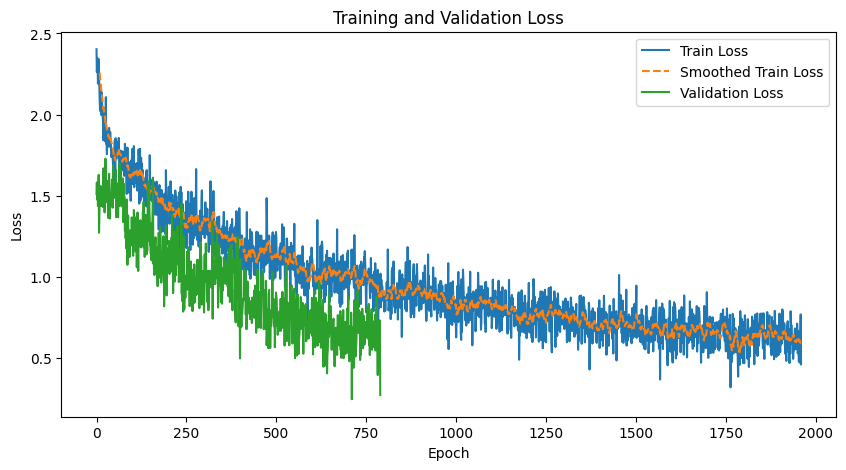

In [64]:
start = time.time()
val_acc = get_acc(model, test_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [77]:
# TODO
def calculate_parameters(width_multiplier):
    model = MobileNetV2(n_class=10, width_multiplier=width_multiplier)
    return sum(p.numel() for p in model.parameters())

# Loop through width multipliers from 0.1 to 1.0 in steps of 0.1
width_multipliers = [round(0.1 * i, 1) for i in range(1, 11)]

for wm in width_multipliers:
    num_params = calculate_parameters(wm)
    print(f"with {wm:.1f} width multipier we got {num_params} parameters")

with 0.1 width multipier we got 81943 parameters
with 0.2 width multipier we got 183048 parameters
with 0.3 width multipier we got 318444 parameters
with 0.4 width multipier we got 487958 parameters
with 0.5 width multipier we got 697258 parameters
with 0.6 width multipier we got 931391 parameters
with 0.7 width multipier we got 1203792 parameters
with 0.8 width multipier we got 1510396 parameters
with 0.9 width multipier we got 1851206 parameters
with 1.0 width multipier we got 2236682 parameters


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [87]:
model1 = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)
epochs = 15
lr = 1e-3
train_losses, val_losses = train(train_loader, test_loader, model1, epochs, lr)


torch.save(model1.state_dict(), './MNv2WMmodel.pt')

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 1.7583, Validation Loss: 1.8437


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/15, Train Loss: 1.4430, Validation Loss: 1.4953


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/15, Train Loss: 1.2677, Validation Loss: 1.4639


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/15, Train Loss: 1.1428, Validation Loss: 1.2610


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/15, Train Loss: 1.0491, Validation Loss: 1.1314


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/15, Train Loss: 0.9687, Validation Loss: 1.0437


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/15, Train Loss: 0.9061, Validation Loss: 0.9506


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/15, Train Loss: 0.8422, Validation Loss: 0.8693


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/15, Train Loss: 0.7938, Validation Loss: 0.8094


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/15, Train Loss: 0.7467, Validation Loss: 0.8424


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/15, Train Loss: 0.7077, Validation Loss: 0.7204


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/15, Train Loss: 0.6873, Validation Loss: 0.7239


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/15, Train Loss: 0.6513, Validation Loss: 0.7308


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/15, Train Loss: 0.6261, Validation Loss: 0.7516


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/15, Train Loss: 0.5916, Validation Loss: 0.6914


In [88]:
MNv2_path = './MNv2WMmodel.pt'
# TODO

state_dict = torch.load(MNv2_path, map_location=device)
model1 = MobileNetV2(n_class=10, width_multiplier=0.5)
model1.load_state_dict(state_dict)
model1.eval()

<ipython-input-88-13a2176ff823>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MNv2_path, map_location=device)


MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(8, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3

In [92]:
start = time.time()
val_acc = get_acc(model1.to(device), test_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))



Val accuracy = 77.09
Process validation time: 10.5827 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

The `width_multiplier` scales the number of channels in each layer, effectively increasing or decreasing the network's width. Specifically:
- If the number of input channels is \( $C_{\text{in}}$ \), it becomes \( $C_{\text{in}} \cdot \text{width\_multiplier}$ \).
- Similarly, the number of output channels is scaled as \( $C_{\text{out}} \cdot \text{width\_multiplier}$ \).

### **Formula for Total Parameters**
For a convolutional layer with \( $C_{\text{in}}$ \) input channels, \( $C_{\text{out}}$ \) output channels, and a kernel size \( K $\times$ K \), the number of parameters is:

$
\text{Parameters} = (C_{\text{in}} \cdot \text{width\_multiplier}) \cdot (C_{\text{out}} \cdot \text{width\_multiplier}) \cdot K \cdot K
$

For the entire model, sum the parameters of all layers, adjusting channels by `width_multiplier`.

### **Comparison with Numbers in Code**
In practice, the theoretical values may slightly differ due to:
- **Rounding**: Channels are integers after scaling.
- **Other layers**: Parameters from batch normalization or fully connected layers.
- **First and last layers**: These may not scale identically to intermediate layers.

The formula provides an approximation, but exact numbers depend on implementation details.

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

The resolution multiplier adjusts the spatial dimensions of the input image. For example, scaling an input size of \( 224 $\times$ 224 \) by 0.5 results in \( 112 $\times$ 112 \).

### **Impact on Speed**
Smaller resolutions reduce the number of computations (FLOPs) because the spatial dimensions affect the number of sliding window operations in convolution:

$
\text{FLOPs} \propto H_{\text{in}} \cdot W_{\text{in}}
$

Thus, reducing the input resolution makes the model faster.

### **Impact on Parameters**
The resolution multiplier **does not** affect the number of parameters because parameters depend on the number of channels and kernel sizes, which remain constant regardless of the input size.

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

While GPUs have improved computational performance, the number of parameters remains important for several reasons:

1. **Memory Usage**: Models with more parameters require more memory, affecting storage and runtime efficiency.
2. **Energy Efficiency**: Fewer parameters result in lower energy consumption, which is critical for mobile and edge devices.
3. **Overfitting Risk**: Models with excessive parameters are more likely to overfit, especially on smaller datasets.
4. **Scalability**: Training large models requires powerful and expensive hardware, limiting accessibility.

Although GPUs mitigate some performance concerns, reducing parameters makes models more portable, efficient, and widely usable.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [93]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [95]:
start = time.time()
val_acc = get_acc(teacher_model, test_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Val accuracy = 7.84
Process validation time: 13.4579 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [96]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        # Scale logits by temperature
        student_logits_temp = student_logits / self.temperature
        teacher_logits_temp = teacher_logits / self.temperature

        # KL divergence loss for distillation
        distillation_loss = self.kl_div(
            F.log_softmax(student_logits_temp, dim=1),
            F.softmax(teacher_logits_temp, dim=1)
        ) * (self.temperature ** 2)

        # Cross-entropy loss for classification
        classification_loss = self.ce_loss(student_logits, labels)

        # Weighted sum of losses
        return self.alpha * distillation_loss + (1 - self.alpha) * classification_loss


def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Get teacher predictions
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Get student predictions
            student_logits = student(inputs)

            # Compute loss
            loss = criterion(student_logits, teacher_logits, labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluate the student model
        student.eval()
        val_acc = get_acc(student, test_loader)
        print(f"Validation Accuracy: {val_acc:.2f}%")            


Train it for one epoch to just check if it works.

In [98]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, test_loader, device, epochs=1, lr=0.001)

Epoch [1/1], Loss: 1.0009
Validation Accuracy: 41.72%


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


The `alpha` parameter in the `DistillationLoss` function controls the weighting between the **distillation loss** (KL divergence) and the **classification loss** (cross-entropy). Adjusting `alpha` directly influences how much the student model learns from the teacher versus the ground truth labels.

---

## **1. High `alpha` (e.g., 0.9)**

### **Advantages**
- **Closer alignment with the teacher model**: The student focuses more on mimicking the teacher's knowledge, potentially capturing fine-grained or nuanced patterns learned by the teacher.
- **Regularization effect**: The teacher's output acts as a soft target, which can guide the student model to generalize better on unseen data, especially when the dataset is noisy or limited.

### **Disadvantages**
- **Over-reliance on the teacher**: If the teacher model has suboptimal performance or is overfitted to its training data, the student might inherit these weaknesses.
- **Reduced focus on ground truth labels**: The student may not prioritize the primary task's explicit ground truth, leading to subpar performance on the target task.

---

## **2. Low `alpha` (e.g., 0.1)**

### **Advantages**
- **Better alignment with ground truth labels**: The student model prioritizes learning directly from the ground truth, which is beneficial if the teacher model is not significantly better than the student.
- **Task-focused learning**: The classification loss dominates, ensuring the student is strongly optimized for the specific target task.

### **Disadvantages**
- **Less benefit from teacher knowledge**: The model may underutilize the teacher's learned knowledge, missing out on potential improvements in generalization or robustness.
- **Higher risk of overfitting**: If the training dataset is small or noisy, the student may overfit without the soft targets provided by the teacher.

---

## **Impact on Student Model Performance**

1. **Generalization**:
   - A high `alpha` encourages the student to generalize better, especially in challenging tasks where the teacher has captured complex patterns.
   - A low `alpha` focuses the model more on task-specific performance but may reduce its ability to generalize to new data.

2. **Alignment with Teacher Knowledge**:
   - A high `alpha` ensures the student closely mimics the teacher, potentially capturing subtle inter-class relationships (soft probabilities).
   - A low `alpha` results in the student aligning less with the teacher, focusing more on hard targets (ground truth labels).

---

## **Conclusion**

The choice of `alpha` should balance the need for generalization and task-specific performance:
- Use a **high `alpha`** if the teacher model is well-trained, robust, and capable of providing valuable guidance.
- Use a **low `alpha`** if the teacher model's performance is comparable to the student's or if task-specific accuracy is more critical than generalization.

Tuning `alpha` through experiments is crucial to find the optimal trade-off for your specific application.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018